## Seq_Data Clustering in PNAS 2015 - Early signaling dynamics of the EGFR

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from msresist.sequence_analysis import preprocess_seqs, FormatName, pYmotifs
from msresist.clustering import MassSpecClustering
import matplotlib.colors as colors
import matplotlib.cm as cm
from msresist.FileExporter import create_download_link


import warnings
warnings.simplefilter("ignore")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.mixture.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


### Make MS Data Compatible

In [2]:
# pd.set_option('display.max_rows', 2000)
# pd.set_option('display.max_columns', 100)
# pd.set_option('display.max_colwidth', 1000)

fulldata = pd.read_csv("msresist/data/Raw/pnas.forestEGF.sd01.csv", header=0).iloc[:, :14].sort_values(by="Protein")
print("number of different peptides captured in this data set: ", fulldata.drop_duplicates(["Protein", "Sequence"]).shape[0])

#Format Name
names = []
list(map(lambda v: names.append(v.split("OS")[0]), fulldata.iloc[:, 0]))
fulldata["Protein"] = names
names = []
list(map(lambda v: names.append(v.split(" [H")[0]), fulldata.iloc[:, 0]))
fulldata["Protein"] = names
names = []
list(map(lambda v: names.append(v.split(" isoform")[0]), fulldata.iloc[:, 0]))
fulldata["Protein"] = names


#Format Seqs and map to proteome to obtain motifs
fulldata["Sequence"] = [seq.replace("(pY)", "y") for seq in list(fulldata.iloc[:, 1])]
fulldata["Sequence"] = [seq.replace("(pS)", "s") for seq in list(fulldata.iloc[:, 1])]
fulldata["Sequence"] = [seq.replace("(pT)", "t") for seq in list(fulldata.iloc[:, 1])]
fulldata["Sequence"] = [seq.replace("(M)", "M") for seq in list(fulldata.iloc[:, 1])]
fulldata = pYmotifs(fulldata, names)
fulldata = preprocess_seqs(fulldata, "Y")

number of different peptides captured in this data set:  463


Split data by treatment conditions:

In [3]:
E100 = fulldata[fulldata["Condition"].str.contains("EGF 100 nM")]
E20 = fulldata[fulldata["Condition"].str.contains("EGF 20 nM") & ~fulldata["Condition"].str.contains("Na3VO4") & ~fulldata["Condition"].str.contains("dasatinib")]
E20_Na3VO4 = fulldata[fulldata["Condition"].str.contains("Na3VO4")]
E20_dasatinib = fulldata[fulldata["Condition"].str.contains("dasatinib")]
E10 = fulldata[fulldata["Condition"].str.contains("EGF 10 nM")]
E5 = fulldata[fulldata["Condition"].str.contains("EGF 5 nM")]
E2_5 = fulldata[fulldata["Condition"].str.contains("EGF 2.5 nM")]
E1 = fulldata[fulldata["Condition"].str.contains("EGF 1 nM")]
E0_4 = fulldata[fulldata["Condition"].str.contains("EGF 0.4 nM")]

Checked if it's worth concatenating, take integral, and frame data set with conditions as features. However, it seems that the number of overlapping peptides is fairly small.

In [4]:
E1020100 = pd.concat([E10, E20, E100])

dups = pd.DataFrame(pd.pivot_table(E1020100, index=["Protein", "Sequence"], aggfunc="size")).reset_index()
dups.columns = ["Protein", "Sequence", "Reps"]
print("overlapping peptides across conditions Erl 10nM, 20nM, 100nM :", dups[dups["Reps"] ==  3].shape[0])

overlapping peptides across conditions Erl 10nM, 20nM, 100nM : 63


### Run Clustering

In [5]:
ncl = 7
GMMweight = 0

#Not being used here, needed for any sklearn-compatible estimator
Y_cv = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw3.csv').iloc[:30, :11]


def plotclustermeans(centers, ncl):
    colors_ = cm.rainbow(np.linspace(0, 1, ncl))

    centers = centers.T

    for i in range(centers.shape[0]):
        ax.plot(centers.iloc[i,:], label = "cluster "+str(i+1), color = colors_[i])
    ax.legend()

    ax.set_xticks(np.arange(centers.shape[1]))
    ax.set_xticklabels(E1020100.columns[5:], rotation=70, rotation_mode="anchor")
    ax.set_ylabel("normalized signal")

As in the SOM clustering they generated, we concatenate E10, E20, and E100 data sets and run the model

In [6]:
data = E1020100.iloc[:, 5:].T 
info = E1020100.iloc[:, :5]

Frist by looking at the sequences only:

#### PAM250

In [7]:
MSC_PAM = MassSpecClustering(info, ncl, GMMweight=GMMweight, distance_method="PAM250").fit(data, Y_cv)

In [8]:
E1020100_PAM = E1020100.assign(Cluster=[lab+1 for lab in list(MSC_PAM.labels_)])
E1020100_PAM[E1020100_PAM["Protein"].str.contains("epidermal growth factor receptor")].sort_values(by="Sequence")

,Protein,Sequence,Condition,Position,BioReps,0s,10s,20s,30s,40s,50s,60s,70s,80s,Cluster


In [9]:
MSC_PAM.clustermembers(E1020100.T)

,Prot_C1,abbv_C1,seqs_C1,UniprotAcc_C1,Pos_C1,r2/Std_C1,BioReps_C1,Prot_C2,abbv_C2,seqs_C2,...,Pos_C6,r2/Std_C6,BioReps_C6,Prot_C7,abbv_C7,seqs_C7,UniprotAcc_C7,Pos_C7,r2/Std_C7,BioReps_C7
0,E3 ubiquitin-protein ligase CBL,2.0,APSPNyDDDDD,EGF 10 nM,Y455-p,0.065701,0.44523,"1-phosphatidylinositol 4,5-bisphosphate phosph...",2.0,RNPGFyVEANP,...,Y253-p,0.578110,0.79130,E3 ubiquitin-protein ligase CBL-B,2.0,PDLSIyLKGDV,EGF 10 nM,Y763-p,0.16636,0.39418
1,Caveolin-1,2.0,MSGGKyVDSEG,EGF 10 nM,Y6-p,0.645000,0.60030,Dedicator of cytokinesis protein 9,2.0,GIASPyTTSTP,...,Y802-p,0.251920,0.56684,Phosphatidylinositol 3-kinase regulatory subun...,2.0,KTRDQyLMWLT,EGF 10 nM,Y580-p,0.63238,0.69489
2,Desmoglein-2,3.0,LVDQPyANEGT,EGF 10 nM,Y979-p,0.223780,0.43812,E3 ubiquitin-protein ligase CBL,2.0,PPDRPySVGAE,...,Y659-p,0.111990,0.23623,Ephrin type-A receptor 2,2.0,KPLKTyVDPHT,EGF 10 nM,Y588-p,0.65105,0.66531
3,Epidermal growth factor receptor,3.0,LDNPDyQQDFF,EGF 10 nM,Y1172-p,0.062655,0.28720,SHC-transforming protein 1,2.0,PPDHQyYNDFP,...,Y627-p,0.058605,0.25260,Glycogen synthase kinase-3 alpha,3.0,EPNVSyICSRY,EGF 10 nM,Y279-p,0.84363,0.98171
4,Epidermal growth factor receptor,3.0,LPVPEyINQSV,EGF 10 nM,Y1092-p,0.074811,0.34431,SHC-transforming protein 1,3.0,PPDHQyYNDFP,...,Y659-p,0.057958,0.20294,Homeodomain-interacting protein kinase 3,2.0,TVCSTyLQSRY,EGF 10 nM,Y359-p,0.85603,0.92287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Y150-p,0.084289,0.43661,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Y150-p,0.064893,0.50406,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Y98-p,0.140580,1.02710,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Y584-p,0.170010,0.42299,NaN,NaN,NaN,NaN,NaN,NaN,NaN


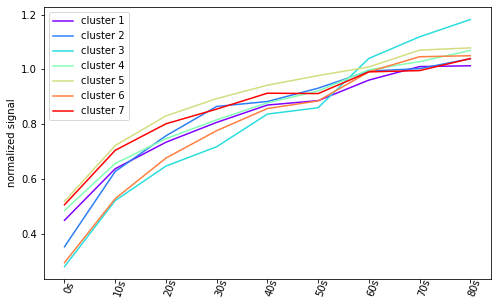

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
centers_PAM = MSC_PAM.transform(data)
plotclustermeans(centers_PAM, ncl)

Including data:

In [11]:
GMMweight = 2.5

MSC_PAM25 = MassSpecClustering(info, ncl, GMMweight=GMMweight, distance_method="PAM250").fit(data, Y_cv)
centers_PAM25 = MSC_PAM25.transform(data)

E1020100_PAM25 = E1020100.assign(Cluster=[lab+1 for lab in list(MSC_PAM25.labels_)])
E1020100_PAM25[E1020100_PAM25["Protein"].str.contains("epidermal growth factor receptor")].sort_values(by="Sequence")

,Protein,Sequence,Condition,Position,BioReps,0s,10s,20s,30s,40s,50s,60s,70s,80s,Cluster


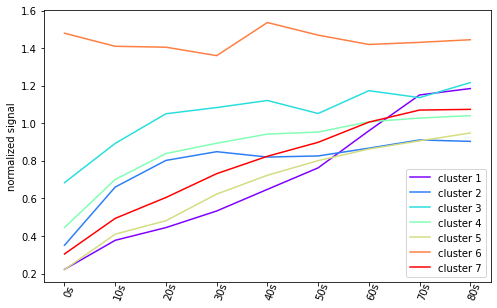

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

plotclustermeans(centers_PAM25, ncl)

In [13]:
MSC_PAM25.clustermembers(E1020100_PAM25.T)

,Prot_C1,abbv_C1,seqs_C1,UniprotAcc_C1,Pos_C1,r2/Std_C1,BioReps_C1,Prot_C2,abbv_C2,seqs_C2,...,Pos_C6,r2/Std_C6,BioReps_C6,Prot_C7,abbv_C7,seqs_C7,UniprotAcc_C7,Pos_C7,r2/Std_C7,BioReps_C7
0,Caskin-2,2.0,NIRNTyNQTAL,EGF 10 nM,Y253-p,0.57811,0.79130,E3 ubiquitin-protein ligase CBL,2.0,APSPNyDDDDD,...,Y771-p,0.27117,0.49984,GRB2-associated-binding protein 1,3.0,SSQDCyDIPRA,EGF 10 nM,Y406-p,0.053138,0.26646
1,OTU domain-containing protein 7B,3.0,SYSNGyREPPE,EGF 10 nM,Y779-p,0.14954,0.21006,Phosphatidylinositol 3-kinase regulatory subun...,2.0,KTRDQyLMWLT,...,Y15-p,1.24140,1.24150,GRB2-associated-binding protein 1,3.0,DKQVEyLDLDL,EGF 10 nM,Y627-p,0.058605,0.25260
2,TOM1-like protein 2,3.0,RKTVTyEDPQA,EGF 10 nM,Y404-p,0.36632,0.43222,SHC-transforming protein 1,3.0,FDDPSyVNVQN,...,Y15-p,1.19810,1.08450,GRB2-associated-binding protein 1,3.0,VDSSLyNLPRS,EGF 10 nM,Y259-p,0.336200,0.47190
3,USP6 N-terminal-like protein,2.0,STASQyDNVPG,EGF 10 nM,Y551-p,0.13499,0.28539,SHC-transforming protein 1,3.0,PPDHQyYNDFP,...,Y15-p,1.50900,1.37790,GRB2-associated-binding protein 1,3.0,DKQVEyLDLDL,EGF 10 nM,Y627-p,0.022278,0.22201
4,Disks large homolog 3,2.0,VDGQDyHFVVS,EGF 10 nM,Y673-p,0.29747,0.43082,SHC-transforming protein 1,3.0,PPDHQyYNDFP,...,Y771-p,0.26031,0.62309,Guanine nucleotide exchange factor VAV2,3.0,WFPSTyVEEEG,EGF 10 nM,Y871-p,0.419490,0.56824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


BINOMIAL:

In [14]:
GMMweight = 0

MSC_BPM = MassSpecClustering(info, ncl, GMMweight=GMMweight, distance_method="Binomial").fit(data, Y_cv)
centers_BPM = MSC_BPM.transform(data)

Re-initialize GMM clusters, empty cluster(s) at iteration 0


In [15]:
E1020100_BPM = E1020100.assign(Cluster=[lab+1 for lab in list(MSC_BPM.labels_)])
E1020100_BPM[E1020100_BPM["Protein"].str.contains("epidermal growth factor receptor")].sort_values(by="Sequence")

,Protein,Sequence,Condition,Position,BioReps,0s,10s,20s,30s,40s,50s,60s,70s,80s,Cluster


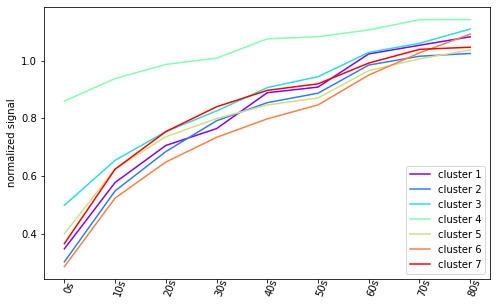

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

plotclustermeans(centers_BPM, ncl)

In [17]:
GMMweight = 2.5

MSC_BPM25 = MassSpecClustering(info, ncl, GMMweight=GMMweight, distance_method="Binomial").fit(data, Y_cv)
centers_BPM25 = MSC_BPM25.transform(data)

E1020100_BPM25 = E1020100.assign(Cluster=[lab+1 for lab in list(MSC_BPM25.labels_)])
E1020100_BPM25[E1020100_BPM25["Protein"].str.contains("epidermal growth factor receptor")].sort_values(by="Sequence")

,Protein,Sequence,Condition,Position,BioReps,0s,10s,20s,30s,40s,50s,60s,70s,80s,Cluster


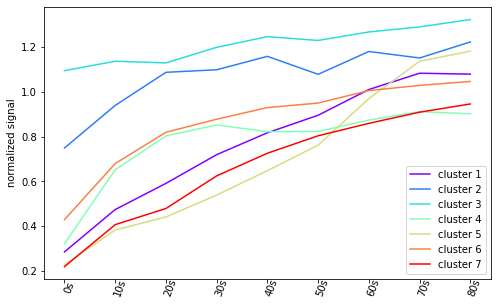

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

plotclustermeans(centers_BPM25, ncl)

In [19]:
# xls = MSC.clustermembers(E1020100.T)
# create_download_link(xls, "PNAS_5Clusters_weight=2.5.csv")